This notebook demonstrates a complete pipeline for training and evaluating an ensemble model to predict GPS coordinates (latitude and longitude) from images. Starting with preprocessed training and testing datasets (4,470 training images and 1,920 testing images) prepared in a separate notebook (Process_Data.ipynb), the data is transformed using normalization techniques suitable for deep learning models (adapting code from the baseline model Notebook provided to us). Multiple custom neural network architectures are trained independently, and an ensemble is created by averaging their predictions. We have the following three models in the ensemble: CNNModel1, CNNModel2, and CNNModel3. The first is an adapted and slightly modified version of AlexNet, the second is an adapted version of ResNet, and the third is an adapted version of GoogLeNet.The ensemble model is evaluated using metrics, such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and geodesic distance in meters. Finally, the ensemble model is serialized, visualized, and uploaded to the Hugging Face Hub, making it accessible for reuse.  For our validation dataset, the ensemble reaches a RMSE of 47.4512 (meters)

# Imports and Packages

In [ ]:
!pip install geopy > delete.txt
!pip install datasets > delete.txt
!pip install torch torchvision datasets > delete.txt
!pip install huggingface_hub > delete.txt
!rm delete.txt
!huggingface-cli login

In [ ]:
from datasets import load_dataset, Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Downloading the train and test Dataset

In [ ]:
dataset_train = load_dataset("CIS-5190-CIA/Training_images", split="train")
dataset_test = load_dataset("CIS-5190-CIA/Testing_images", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/365 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4469 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/361 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1916 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train)
print(dataset_test)

Dataset({
    features: ['Latitude', 'Longitude', 'image'],
    num_rows: 4469
})
Dataset({
    features: ['Latitude', 'Longitude', 'image'],
    num_rows: 1916
})


# Creating Dataloaders and Vizualization

In [ ]:
class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # normalize the latitude and longitude
        self.latitudes = np.array(hf_dataset['Latitude'])
        self.longitudes = np.array(hf_dataset['Longitude'])
        self.latitude_mean = lat_mean if lat_mean is not None else self.latitudes.mean()
        self.latitude_std = lat_std if lat_std is not None else self.latitudes.std()
        self.longitude_mean = lon_mean if lon_mean is not None else self.longitudes.mean()
        self.longitude_std = lon_std if lon_std is not None else self.longitudes.std()

        self.normalized_latitudes = (self.latitudes - self.latitude_mean) / self.latitude_std
        self.normalized_longitudes = (self.longitudes - self.longitude_mean) / self.longitude_std

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        image = self.hf_dataset[idx]['image']
        latitude = self.normalized_latitudes[idx]
        longitude = self.normalized_longitudes[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([latitude, longitude], dtype=torch.float)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = GPSImageDataset(hf_dataset=dataset_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

lat_mean, lat_std = train_dataset.latitude_mean, train_dataset.latitude_std
lon_mean, lon_std = train_dataset.longitude_mean, train_dataset.longitude_std

val_dataset = GPSImageDataset(
    hf_dataset=dataset_test,
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# testing the dataloader
for images, gps_coords in train_dataloader:
    print(images.size(), gps_coords.size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 2])


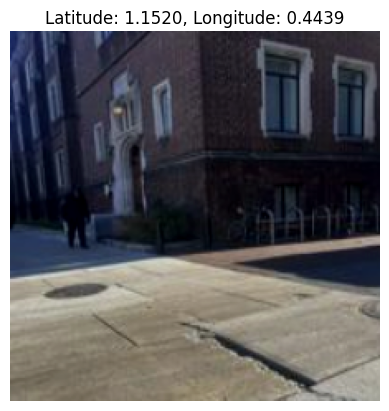

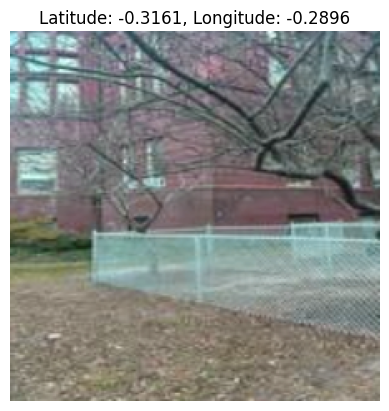

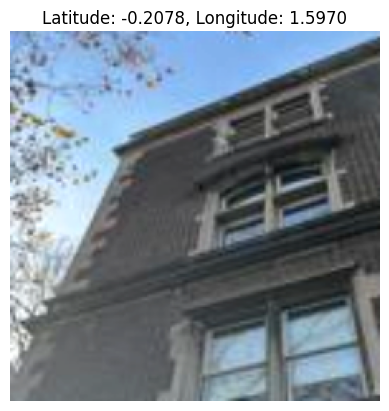

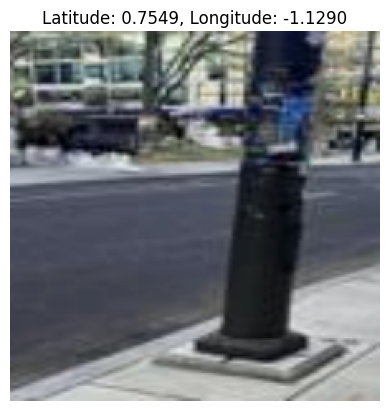

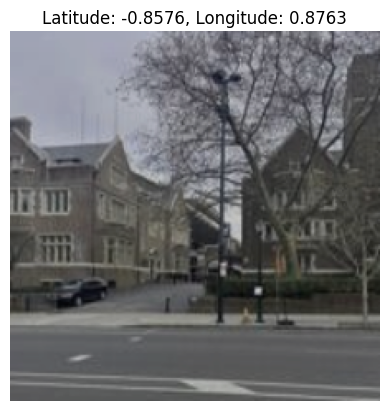

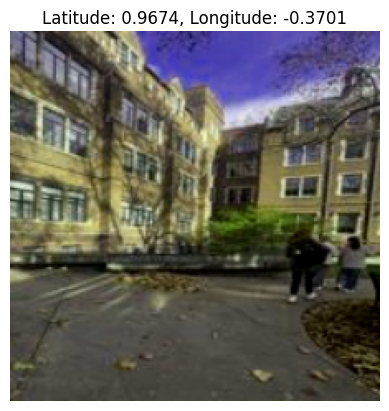

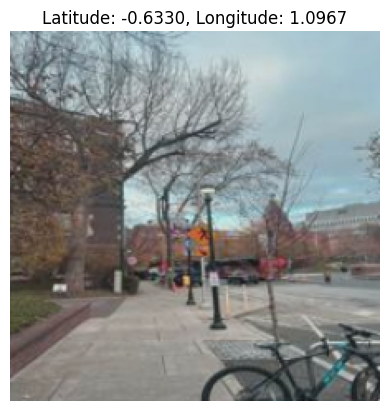

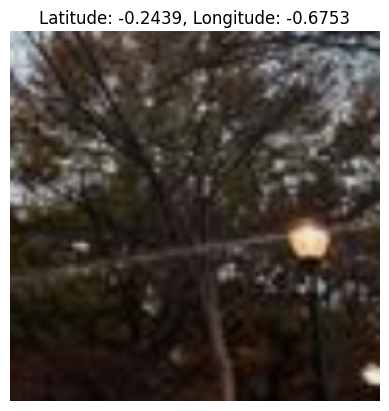

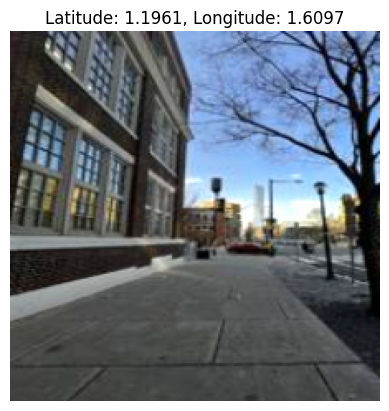

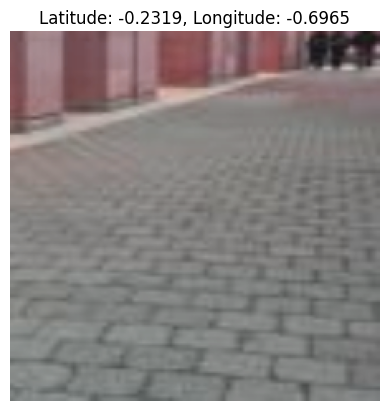

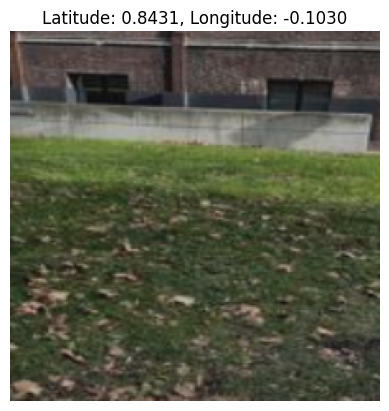

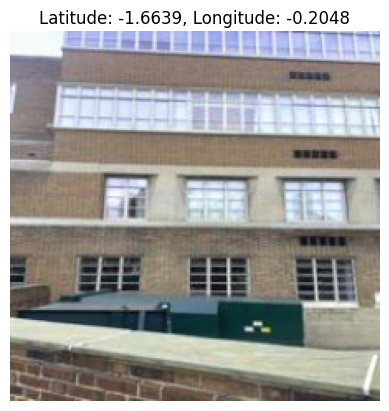

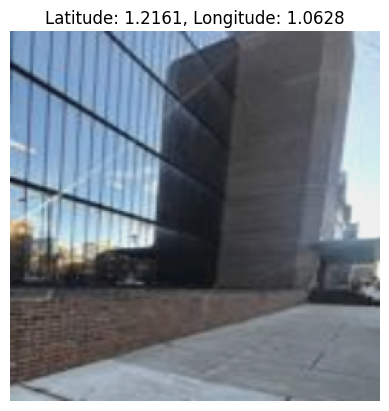

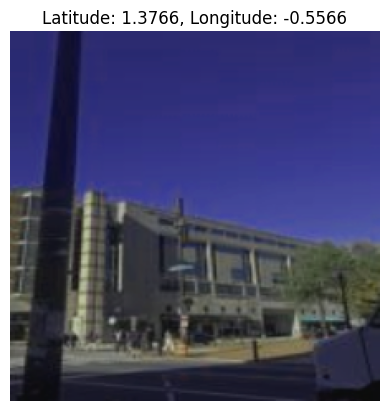

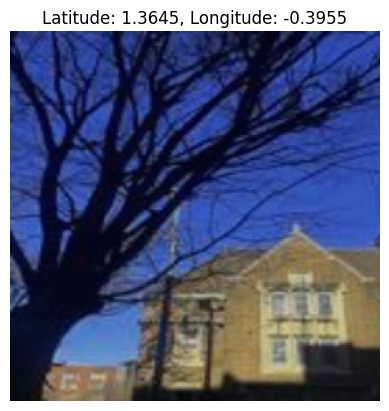

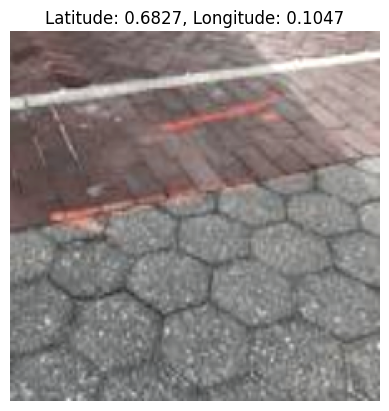

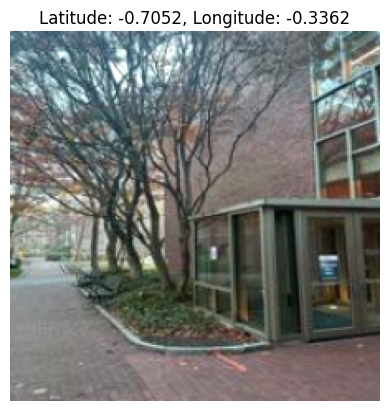

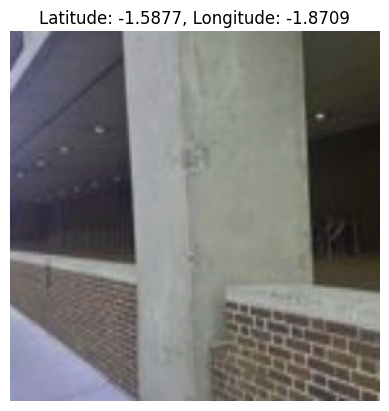

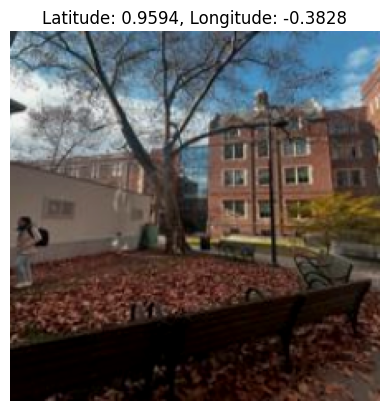

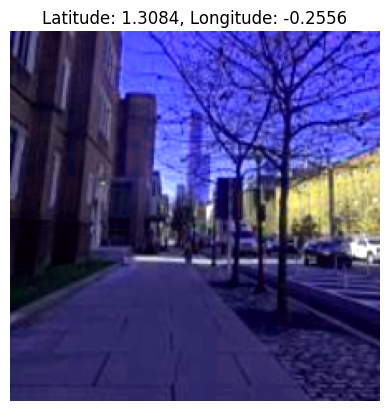

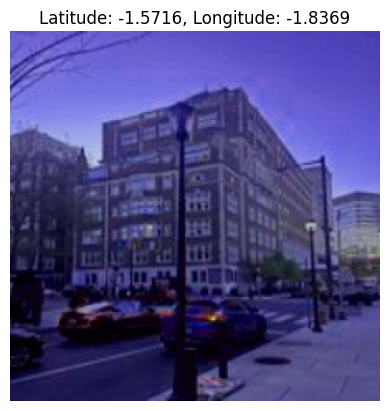

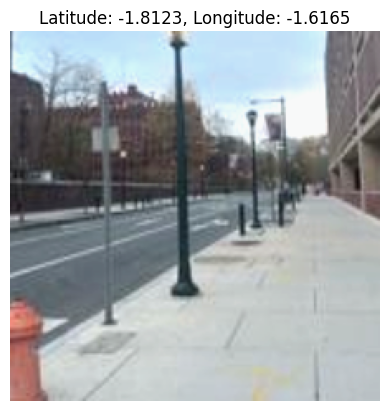

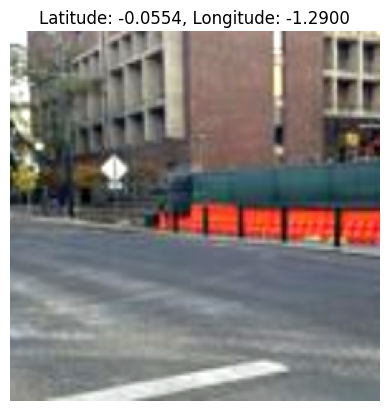

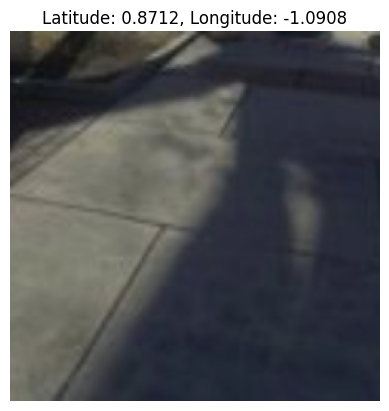

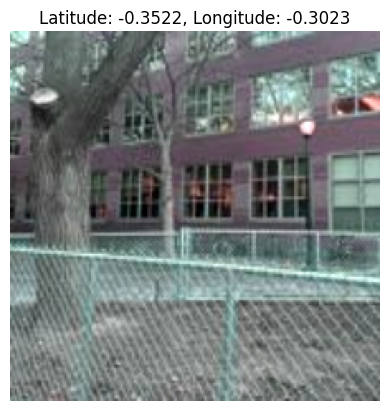

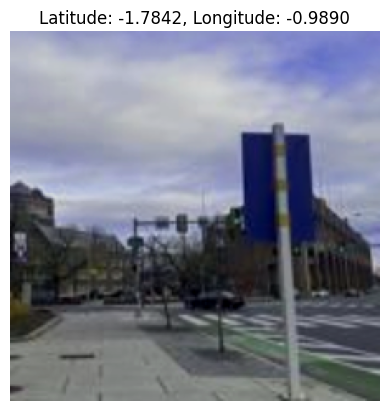

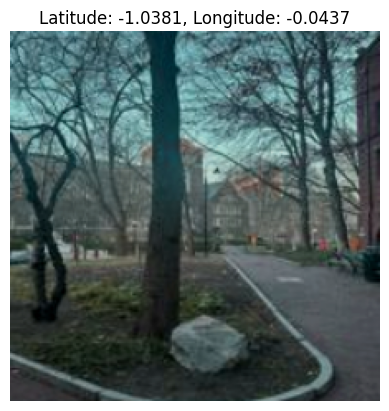

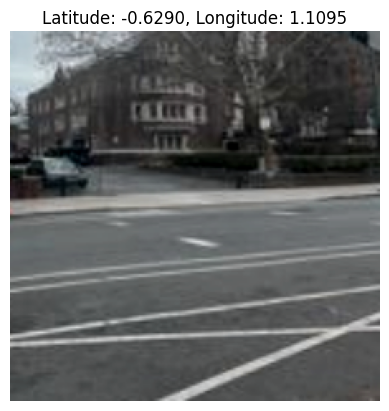

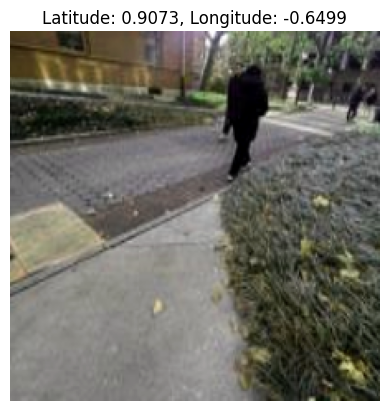

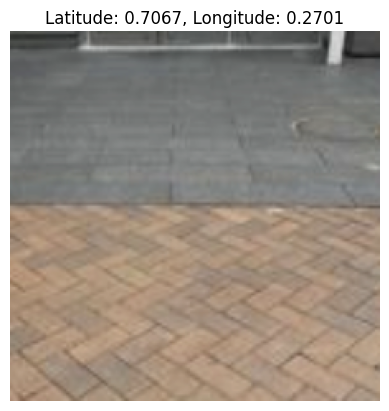

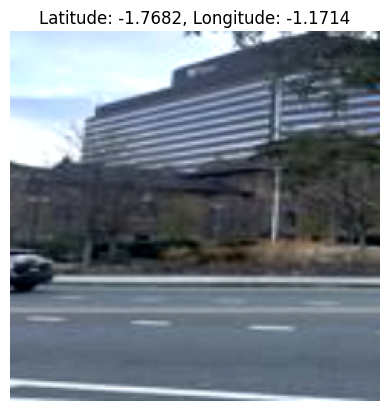

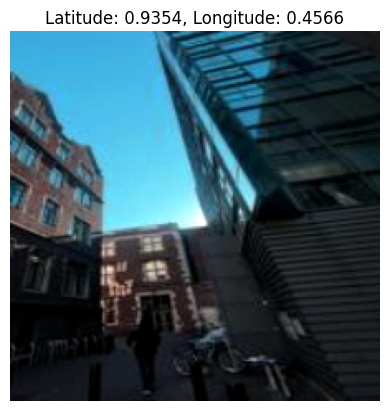

In [ ]:
def denormalize(tensor, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convert from C x H x W to H x W x C
    tensor = std * tensor + mean  # Denormalize
    tensor = np.clip(tensor, 0, 1)  # Clip to keep pixel values between 0 and 1
    return tensor

data_iter = iter(train_dataloader)
images, gps_coords = next(data_iter)  # Get a batch of images and labels
# Denormalize the first image in the batch for display
itr = 0
for im in images:
  image = denormalize(im, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  # Plot the image
  plt.imshow(image)
  plt.title(f'Latitude: {gps_coords[itr][0].item():.4f}, Longitude: {gps_coords[itr][1].item():.4f}')
  plt.axis('off')
  plt.show()
  itr += 1

# Defining Models for Ensemble

Model Class 1

In [ ]:
class CNNModel1(nn.Module):
    def __init__(self, num_outputs=2):
        super(CNNModel1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Model Class 2

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CNNModel2(nn.Module):
    def __init__(self, num_outputs=2):
        super(CNNModel2, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_outputs)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Model Class 3

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2),
            nn.ReLU(inplace=True)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
        return outputs

class CNNModel3(nn.Module):
    def __init__(self, num_outputs=2):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2)

        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.maxpool4 = nn.MaxPool2d(3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.maxpool4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model1 = CNNModel1(num_outputs=2)
model2 = CNNModel2(num_outputs=2)
model3 = CNNModel3(num_outputs=2)

# Training and Testing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
criterion = nn.MSELoss()

# baseline Metrics Function (Geodesic Distance)
def compute_baseline_metrics(dataloader, lat_mean, lon_mean, lat_std, lon_std):
    """
    Computes baseline metrics using mean latitude and longitude as predictions.
    """
    all_targets = []
    for _, targets in dataloader:
        all_targets.append(targets)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

    # denormalize targets
    actuals_denorm = all_targets * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    baseline_preds = np.array([lat_mean, lon_mean])

    baseline_loss = 0.0
    for actual in actuals_denorm:
        distance = geodesic((actual[0], actual[1]), (baseline_preds[0], baseline_preds[1])).meters
        baseline_loss += distance ** 2  # squared geodesic distance

    baseline_loss /= len(actuals_denorm)
    baseline_rmse = np.sqrt(baseline_loss)
    return baseline_loss, baseline_rmse

# training Function with Epoch Logging
def train_model_with_logging(model, train_loader, val_loader, criterion, optimizer, lat_mean, lon_mean, lat_std, lon_std, num_epochs=10):
    model = model.to(device)
    baseline_loss, baseline_rmse = compute_baseline_metrics(val_loader, lat_mean, lon_mean, lat_std, lon_std)

    for epoch in range(num_epochs):
        # training phase
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total_samples = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)

                # Denormalize predictions and targets
                preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
                actuals_denorm = targets.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

                # Compute geodesic distances
                for pred, actual in zip(preds_denorm, actuals_denorm):
                    distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                    val_loss += distance ** 2  # Squared geodesic distance

                total_samples += targets.size(0)

        val_loss /= total_samples
        val_rmse = np.sqrt(val_loss)

        # Print Epoch Progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Training Loss (meters^2): {train_loss:.2f}, "
              f"Validation Loss (meters^2): {val_loss:.2f}, Baseline Loss (meters^2): {baseline_loss:.2f}")
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Validation RMSE (meters): {val_rmse:.2f}, Baseline RMSE (meters): {baseline_rmse:.2f}")

In [ ]:
models = {
    "RNNModel1": CNNModel1(num_outputs=2).to(device),
    "RNNModel2": CNNModel2(num_outputs=2).to(device),
    "RNNModel3": CNNModel3(num_outputs=2).to(device),
}

# Mean and std for denormalization
lat_mean, lon_mean = train_dataset.latitude_mean, train_dataset.longitude_mean
lat_std, lon_std = train_dataset.latitude_std, train_dataset.longitude_std

# Train and Evaluate Each Model with Logs
trained_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_model_with_logging(model, train_dataloader, val_dataloader, criterion, optimizer,
                             lat_mean, lon_mean, lat_std, lon_std, num_epochs=10)
    trained_models[model_name] = model

Training RNNModel1...
Epoch [1/10], Training Loss (meters^2): 0.78, Validation Loss (meters^2): 4617.08, Baseline Loss (meters^2): 8896.95
Epoch [1/10], Validation RMSE (meters): 67.95, Baseline RMSE (meters): 94.32
Epoch [2/10], Training Loss (meters^2): 0.68, Validation Loss (meters^2): 4419.21, Baseline Loss (meters^2): 8896.95
Epoch [2/10], Validation RMSE (meters): 66.48, Baseline RMSE (meters): 94.32
Epoch [3/10], Training Loss (meters^2): 0.63, Validation Loss (meters^2): 4132.19, Baseline Loss (meters^2): 8896.95
Epoch [3/10], Validation RMSE (meters): 64.28, Baseline RMSE (meters): 94.32
Epoch [4/10], Training Loss (meters^2): 0.58, Validation Loss (meters^2): 3118.61, Baseline Loss (meters^2): 8896.95
Epoch [4/10], Validation RMSE (meters): 55.84, Baseline RMSE (meters): 94.32
Epoch [5/10], Training Loss (meters^2): 0.54, Validation Loss (meters^2): 3389.06, Baseline Loss (meters^2): 8896.95
Epoch [5/10], Validation RMSE (meters): 58.22, Baseline RMSE (meters): 94.32
Epoch [6

In [ ]:
def ensemble_predict(models, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    model_outputs = []
    for model_name, model in models.items():
        model.eval()
        outputs = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                outputs.append(model(images))
        model_outputs.append(torch.cat(outputs, dim=0))

    # average the predictions across all models
    ensemble_output = torch.stack(model_outputs, dim=0).mean(dim=0)

    # denormalize the ensemble predictions
    ensemble_output_denorm = ensemble_output.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    return ensemble_output_denorm

# evaluate Ensemble with Geodesic Distance
def evaluate_ensemble(models, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    ensemble_outputs = ensemble_predict(models, dataloader, lat_mean, lon_mean, lat_std, lon_std)

    all_targets = []
    for _, targets in dataloader:
        all_targets.append(targets)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()
    all_targets_denorm = all_targets * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

    total_samples = all_targets_denorm.shape[0]
    ensemble_loss = 0.0

    # compute Geodesic Distance Metrics
    for pred, actual in zip(ensemble_outputs, all_targets_denorm):
        distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
        ensemble_loss += distance ** 2

    ensemble_loss /= total_samples
    ensemble_rmse = np.sqrt(ensemble_loss)
    return ensemble_loss, ensemble_rmse

# evaluate
ensemble_loss, ensemble_rmse = evaluate_ensemble(trained_models, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)

print(f"Ensemble - Loss (meters^2): {ensemble_loss:.4f}, RMSE (meters): {ensemble_rmse:.4f}")

Ensemble - Loss (meters^2): 2251.6196, RMSE (meters): 47.4512


# Testing the learnt Model

In [ ]:
def evaluate_ensemble_with_metrics(models, dataloader, lat_mean, lon_mean, lat_std, lon_std):
    """
    Evaluates the ensemble using mean absolute error, RMSE, and other metrics.
    Returns denormalized predictions and actual values for visualization.
    """
    all_preds = []
    all_actuals = []

    # Generate ensemble predictions
    model_outputs = []
    for model_name, model in models.items():
        model.eval()
        outputs = []
        with torch.no_grad():
            for images, _ in dataloader:
                images = images.to(device)
                outputs.append(model(images))
        model_outputs.append(torch.cat(outputs, dim=0))

    # Average the predictions across all models
    ensemble_output = torch.stack(model_outputs, dim=0).mean(dim=0)

    # Split the averaged predictions into batches to match actuals
    ensemble_output_batches = torch.split(ensemble_output, [batch[0].size(0) for batch in dataloader])

    for batch_idx, (_, gps_coords) in enumerate(dataloader):
        gps_coords = gps_coords.cpu()
        actuals_denorm = gps_coords * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])
        preds_denorm = ensemble_output_batches[batch_idx].cpu() * torch.tensor([lat_std, lon_std]) + torch.tensor([lat_mean, lon_mean])

        all_preds.append(preds_denorm)
        all_actuals.append(actuals_denorm)

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_actuals = torch.cat(all_actuals).numpy()

    # Compute error metrics
    mae = mean_absolute_error(all_actuals, all_preds)
    rmse = mean_squared_error(all_actuals, all_preds, squared=False)

    print(f"Ensemble Metrics:")
    print(f"Mean Absolute Error (meters): {mae}")
    print(f"Root Mean Squared Error (meters): {rmse}")

    return all_preds, all_actuals

all_preds, all_actuals = evaluate_ensemble_with_metrics(trained_models, val_dataloader, lat_mean, lon_mean, lat_std, lon_std)

Ensemble Metrics:
Mean Absolute Error (meters): 0.00027533745573581205
Root Mean Squared Error (meters): 0.00034763049951211546


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Visualization of Prediction

In [ ]:
def visualize_predictions(all_preds, all_actuals, lat_mean, lon_mean, lat_std, lon_std):
    """
    Visualizes actual and predicted GPS coordinates on a scatter plot,
    including error lines connecting each prediction to its corresponding actual point.
    """
    # Denormalize predictions and actual values
    all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

    # Create scatter plot
    plt.figure(figsize=(10, 5))

    # Plot actual points
    plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)

    # Plot predicted points
    plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)

    # Draw lines connecting actual and predicted points
    for i in range(len(all_actuals_denorm)):
        plt.plot(
            [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
            [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
            color='gray', linewidth=0.5
        )

    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
    plt.grid(True)
    plt.show()

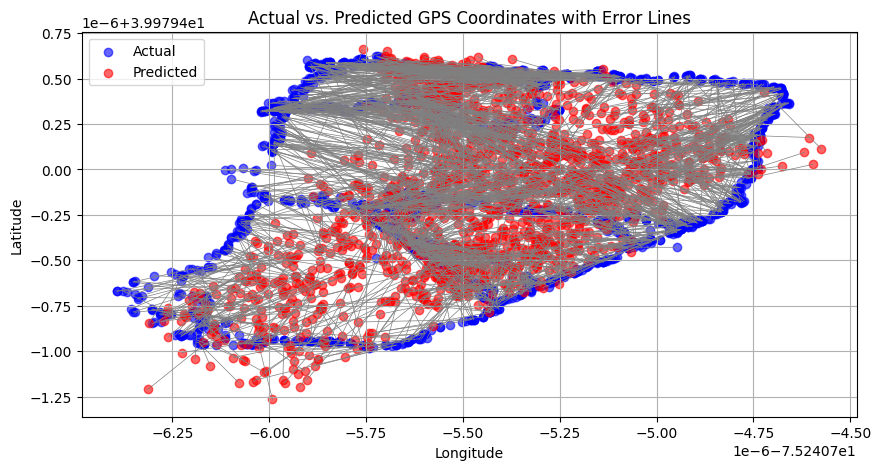

In [ ]:
visualize_predictions(all_preds, all_actuals, lat_mean, lon_mean, lat_std, lon_std)

# Uploading to Hugging Face

In [ ]:
from huggingface_hub import Repository
import pickle

In [ ]:
save_directory = "./ensemble_model"

ensemble_model = {
    model_name: model.state_dict() for model_name, model in trained_models.items()
}

pickle_file = "ensemble_model.pkl"
with open(pickle_file, "wb") as f:
    pickle.dump(ensemble_model, f)
    print(f"Ensemble model saved to {pickle_file}")

with open(pickle_file, "rb") as f:
    loaded_ensemble = pickle.load(f)
    print("Ensemble model loaded successfully!")

for model_name, state_dict in loaded_ensemble.items():
    trained_models[model_name].load_state_dict(state_dict)
    print(f"Restored {model_name} state from pickle.")

Ensemble model saved to ensemble_model.pkl
Ensemble model loaded successfully!
Restored RNNModel1 state from pickle.
Restored RNNModel2 state from pickle.
Restored RNNModel3 state from pickle.


In [ ]:
pickle_file = "ensemble_model.pkl"
with open(pickle_file, "wb") as f:
    pickle.dump(ensemble_model, f)
    print(f"Ensemble model saved to {pickle_file}")

Ensemble model saved to ensemble_model.pkl


Download the pickle locally and upload manually to hugging face